In [1]:
import pandas as pd # data science library o manipulate data
import numpy as np # mathematical library to manipulate arrays and matrices
import matplotlib.pyplot as plt # visualization ~
import urllib.request
import os
import re
from statsmodels.tsa.ar_model import AutoReg
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import statsmodels.api as sm

#FUNCAO PARA FAZER AS MÉTRICAS

In [2]:
def evaluating_models(test,predictions):
    MAE=metrics.mean_absolute_error(test,predictions) #Mean Absolute Error
    MBE=np.mean(test-predictions) #  Mean Bias Error
    MSE=metrics.mean_squared_error(test,predictions)  
    RMSE= np.sqrt(metrics.mean_squared_error(test,predictions))# Root Mean Squared Error  
    cvRMSE=RMSE/np.mean(test) #cv Root Mean Squared Error  
    NMBE=MBE/np.mean(test) #Normalized Mean Bias Error:
    return MAE, MBE,MSE,RMSE,cvRMSE,NMBE

############################################# CRIAR FOLDERS PARA GUARDAR AS IMAGENS ########################################################################

In [3]:
emissions_countries = r'emissions_countries' 
if not os.path.exists(emissions_countries):
    os.makedirs(emissions_countries)
    
weatherf = r'weatherf' 
if not os.path.exists(weatherf):
    os.makedirs(weatherf)
    
elect_prod = r'elect_prod' 
if not os.path.exists(elect_prod):
    os.makedirs(elect_prod)
    
flights = r'flights' 
if not os.path.exists(flights):
    os.makedirs(flights)

features_tests = r'features_tests' 
if not os.path.exists(features_tests):
    os.makedirs(features_tests)   
    
regressions = r'regressions' 
if not os.path.exists(regressions):
    os.makedirs(regressions)

co2 = r'regressions/co2' 
if not os.path.exists(co2):
    os.makedirs(co2)  

energy = r'regressions/energy' 
if not os.path.exists(energy):
    os.makedirs(energy)
    
forecast = r'forecast' 
if not os.path.exists(forecast):
    os.makedirs(forecast)
    
co2 = r'forecast/co2' 
if not os.path.exists(co2):
    os.makedirs(co2)
    
energy = r'forecast/energy' 
if not os.path.exists(energy):
    os.makedirs(energy)

In [4]:
blue=["deepskyblue","skyblue","steelblue","dodgerblue","royalblue","blue"]

############################################################ TRATAMENTO DOS DADOS ##########################################################################

In [5]:
carbon_eu = pd.read_csv('carbon_eu.csv')  #dados das emissoes de carbono para todos os paises e os setores onde libertam

energy_prod = pd.read_csv('energy_prod.csv') #dados da produção de energia para todos os paises e os tipos de energia

carbon_eu=carbon_eu.dropna() 

energy_prod=energy_prod.dropna() 

date_range = pd.date_range(start='2021-01-01', end='2023-01-01', freq='D') #O intervalo de datas com as quais vamos trabalhar

countries=["Portugal","Spain","France","Germany","Belgium","Italy"] #Colocar mais paises à medida que conseguimos descarregar (é importante meter o resto é automático)

weather_cond=['Temperature [ºC]','Wind Speed [km/h]','Relative Humidity (%)','Pressure [mbar]','Solar Radiation [W/m^2]','Rain [mm/h]'] #Weather conditions que escolhemos

sectors_co2=list(set(carbon_eu["sector"])) #criar uma lista para os vários setores do CO2

sectors_en=list(set(energy_prod["sector"])) #criar uma lista para os varios tipos de energias

years=["2021","2022","2023"] #anos que vamos ver

############################ Tratamento dos dados em loop para os vários paises e a junção de todos os ficheiros excel ##########################

In [6]:
for country in countries:
    
    meteo = pd.read_csv(f'meteo_data/meteo_{country}.csv')
    
    meteo.index = date_range
    
    meteo.index.name="Date"
    
    meteo.rename(columns={'temp': 'Temperature [ºC]', 'windspeed': 'Wind Speed [km/h]',"humidity": 'Relative Humidity (%)',
                                'sealevelpressure': 'Pressure [mbar]','solarradiation': 'Solar Radiation [W/m^2]', 'precip': 'Rain [mm/h]'}, inplace=True)
    
        
    df_country = carbon_eu[(carbon_eu['country'] == country)] 
    
    for sector in sectors_co2:
        sector_list = df_country[(df_country['sector'] == sector)]
        sector_list = sector_list.drop(columns=['timestamp','sector'])
        sector_list.rename(columns={'value': f'{sector}', 'date': 'Date'}, inplace=True)
        globals()[f"{sector.replace(' ', '_')}"]= sector_list 
    df_country = pd.merge(Power, Ground_Transport, on=["Date","country"], how='inner')

    # Merge all types of energy 
    df_country  = pd.merge(df_country , International_Aviation, on=["Date","country"], how='inner')
    df_country  = pd.merge(df_country , Residential, on=["Date","country"], how='inner')
    df_country  = pd.merge(df_country , Industry, on=["Date","country"], how='inner')
    df_country  = pd.merge(df_country , Domestic_Aviation, on=["Date","country"], how='inner')
    
    df_country["Total CO2 [Tonne]"]= df_country["Power"]+df_country["International Aviation"]+df_country["Residential"]+df_country["Industry"]+df_country["Domestic Aviation"]
    df_country[['Day','Month','Year']] = df_country.Date.str.split("/",expand=True) 
    df_country = df_country.drop(columns=['Date'])
    df_country['Date'] = pd.to_datetime(df_country[['Day', 'Month', 'Year']])
    df_country = df_country.drop(columns=['Year', 'Month', 'Day'])
    df_country.set_index('Date', inplace=True)
    
    df_en = energy_prod[(energy_prod['country'] == country)] 
    
    for sector in sectors_en:
        sector_list = df_en[(df_en['sector'] == sector)]
        sector_list = sector_list.drop(columns=['timestamp','sector'])
        sector_list.rename(columns={'value': f'{sector}', 'date': 'Date'}, inplace=True)
        globals()[f"{sector.replace(' ', '_')}"]= sector_list 
    df_en = pd.merge(Other_sources, Gas, on=["Date","country"], how='inner')

    # Merge all types of energy 
    df_en  = pd.merge(df_en , Oil, on=["Date","country"], how='inner')
    df_en  = pd.merge(df_en , Coal, on=["Date","country"], how='inner')
    df_en  = pd.merge(df_en ,  Wind, on=["Date","country"], how='inner')
    df_en  = pd.merge(df_en ,Nuclear, on=["Date","country"], how='inner')
    
    df_en  = pd.merge(df_en ,Solar, on=["Date","country"], how='inner')
    
    df_en  = pd.merge(df_en ,Hydroelectricity, on=["Date","country"], how='inner')
    
    df_en["Total Renewable [GWh]"]= df_en["Wind"]+ df_en["Solar"] + df_en["Hydroelectricity"]
    df_en["Total Non-Renewable [GWh]"]= df_en["Other sources"]+df_en["Gas"]+df_en["Oil"]+df_en["Coal"]+ df_en["Nuclear"]
    
    df_en["Total Electricity [GWh]"]= df_en["Other sources"]+df_en["Gas"]+df_en["Oil"]+df_en["Coal"]+df_en["Wind"]+ df_en["Nuclear"] + df_en["Solar"] + df_en["Hydroelectricity"]
    
    df_en[['Day','Month','Year']] = df_en.Date.str.split("/",expand=True) 
    df_en = df_en.drop(columns=['Date'])
    df_en['Date'] = pd.to_datetime(df_en[['Day', 'Month', 'Year']])
    df_en = df_en.drop(columns=['Year', 'Month', 'Day'])
    df_en.set_index('Date', inplace=True)
    
    df_country  = pd.merge(df_country , meteo, on=["Date"], how='inner')
    
    df_country  = pd.merge(df_country , df_en, on=["Date","country"], how='inner')
    
    df_country=df_country.dropna() 
    
    df_list=[]
    
    for year in years:
        df = pd.read_excel(f"flights_data/{year}flight.xlsx", sheet_name="Data")
        df = df[(df['Entity'] == country)] 
        df_list.append(df)
    
    flights= pd.concat(df_list)
    
    flights['Year'] = flights['Day'].dt.year
    flights['Month'] = flights['Day'].dt.month
    flights['Day'] = flights['Day'].dt.day
    flights['Date'] = pd.to_datetime(flights[['Year', 'Month', 'Day']])
    flights = flights.drop(columns=['Year','Week', 'Month', 'Day','Flights (7-day moving average)','Day 2019', 'Flights 2019 (Reference)',	'% vs 2019 (Daily)','% vs 2019 (7-day Moving Average)',	'Day Previous Year',	'Flights Previous Year'])
    flights.set_index('Date', inplace=True)
    
    flights.rename(columns={'Entity':'country'}, inplace=True)
    
    df_country  = pd.merge(df_country , flights, on=["Date","country"], how='inner')
    
    globals()[f"{country.replace(' ', '_')}"]= df_country
    
    globals()[f"{country.replace(' ', '_')}"]=globals()[f"{country.replace(' ', '_')}"].dropna() 
    
    if "datetime" in globals()[f"{country.replace(' ', '_')}"].columns:
        globals()[f"{country.replace(' ', '_')}"] = globals()[f"{country.replace(' ', '_')}"].drop(columns=['datetime'])
        

ma coisa importante daqui é que o ficheiro final é o globals()[f"{country.replace(' ', '_')}"] isto porque a partida vamos sempre fazer um loop para os countries<br>
e não nos necessitamos de preocupar em dar um nome um a um. Este é o nome do nosso dataframe final

############################################### Plots só para analisar se a data está toda mais ou menos em ordem ################################################

In [7]:
for country in countries:
    i=0
    
    plt.figure(figsize=(12,6))   
    for sector in sectors_co2:
        plt.plot(globals()[f"{country.replace(' ', '_')}"][f'{sector}'], 
                 label=sector, color=blue[i])
        i=i+1
        plt.legend()
    plt.xlabel("Date")
    plt.ylabel("CO^2 Emissions in Tonne")
    plt.title(f'{country} emissions for each sector')
    plt.savefig(f"emissions_countries/{country}_emissions.png") 
    plt.clf()
    
    plt.figure(figsize=(12,6))
    i=0
    for sector in sectors_en:
        plt.plot(globals()[f"{country.replace(' ', '_')}"][f'{sector}'], 
                 label=sector)
        i=i+1
        plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Energy Production in GWh")
    plt.title(f'{country} Energy Production for each sector')
    plt.savefig(f"elect_prod/{country}_elect_prod.png") 
    plt.clf()
    
    plt.figure(figsize=(12,6))   
    
    for weather in weather_cond:
        weather_name = re.split(r'\s|\[', weather)[0]
        plt.plot(globals()[f"{country.replace(' ', '_')}"][f'{weather}'], 
                 label=weather)
        i=i+1
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel(f"{weather}")
        plt.title(f'{weather} for {country}')
        plt.savefig(f"weatherf/{country}_{weather_name}.png") 
        plt.clf()
 
 
plt.figure(figsize=(12,6))   

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [8]:
for country in countries:
    
    plt.plot(globals()[f"{country.replace(' ', '_')}"]['Total CO2 [Tonne]'], 
                label=country)   
    
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol=8)
plt.subplots_adjust(bottom=0.3)
plt.xlabel("Date")
plt.ylabel("CO^2 Emissions in Tonne")
plt.title(f'Total emissions for each country')
plt.savefig(f"emissions_countries/Total_emissions.png") 
plt.clf()

<Figure size 640x480 with 0 Axes>

In [9]:
for country in countries:
    
    plt.plot(globals()[f"{country.replace(' ', '_')}"]['Total Electricity [GWh]'], 
                label=country)
    
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol=8)
plt.subplots_adjust(bottom=0.3)
plt.xlabel("Date")
plt.ylabel("Total Energy Producted in GWh")
plt.title(f'Total Energy Production for each country')
plt.savefig(f"elect_prod/Total_prod.png") 
plt.clf()

<Figure size 640x480 with 0 Axes>

In [10]:
for country in countries:
    
    plt.plot(globals()[f"{country.replace(' ', '_')}"]['Flights'], 
                label=country)
    
plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol=8)
plt.subplots_adjust(bottom=0.3)
plt.xlabel("Date")
plt.ylabel("Number of Flights per day")
plt.title(f'Number of flights for each country')
plt.savefig(f"flights/flights.png") 
plt.clf()

<Figure size 640x480 with 0 Axes>

In [11]:
for country in countries:
    
    plt.plot(globals()[f"{country.replace(' ', '_')}"]['Total Renewable [GWh]'], 
                label= "Renewable Sources (Wind, Solar, Hydro)")
    plt.plot(globals()[f"{country.replace(' ', '_')}"]['Total Non-Renewable [GWh]'], 
                label= "Non-Renewable Sources (Oil, Coal, Gas, Nuclear, Other Sources)")
    
    plt.legend(loc="upper center",bbox_to_anchor=(0.5, -0.2),ncol=8)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("Date")
    plt.ylabel("Energy Producted in GWh")
    plt.title(f'Renewable vs Non-Renewable energy production {country}')
    plt.savefig(f"elect_prod/Total_prod_{country}.png") 
    plt.clf()

<Figure size 640x480 with 0 Axes>

############################################## Começar a fazer as features selections ########################################################################################

In [12]:
 
from sklearn.feature_selection import SelectKBest # selection method
from sklearn.feature_selection import mutual_info_regression,f_regression

In [13]:
high_feat_temp_co = {}
high_feat_temp_en= {}

Index(['country', 'Power', 'Ground Transport', 'International Aviation',
       'Residential', 'Industry', 'Domestic Aviation', 'Total CO2 [Tonne]',
       'Temperature [ºC]', 'Relative Humidity (%)', 'Rain [mm/h]',
       'Wind Speed [km/h]', 'Pressure [mbar]', 'Solar Radiation [W/m^2]',
       'Other sources', 'Gas', 'Oil', 'Coal', 'Wind', 'Nuclear', 'Solar',
       'Hydroelectricity', 'Total Renewable [GWh]',
       'Total Non-Renewable [GWh]', 'Total Electricity [GWh]', 'Flights',
       'CO2 Emission-1 [kW]', '3 Last CO2 Mean', 'Ren Energy-1 [kW]',
       '3 Last Ren Energy Mean'],
      dtype='object')
Highest features scores for CO2 as Output with kBest for Portugal:

CO2 Emission-1 [kW]: 1.3476716446887536
Gas: 1.3183762512590138
3 Last CO2 Mean: 0.8096919963489664
Solar: 0.29047437186022984
Hydroelectricity: 0.2821579512187977
Flights: 0.23004877471742713
Other sources: 0.20998540198621507
Wind: 0.1855994560712313
Coal: 0.15780414692948774


Highest features importances for CO

Highest features importances for CO2 as Output with RandomForestRegressor:

CO2 Emission-1 [kW]: 0.9833170736788979
Temperature [ºC]: 0.0036420800991927974
3 Last CO2 Mean: 0.002436798839915906
Coal: 0.0023788814466815015
Gas: 0.0011973116980022527
Wind Speed [km/h]: 0.0009098340960675878
Hydroelectricity: 0.000679915822505936
Wind: 0.000651277548291765
Rain [mm/h]: 0.0006331581401793039


Best features for CO2 emission after both tests:
[('CO2 Emission-1 [kW]', 34), ('3 Last CO2 Mean', 31), ('Temperature [ºC]', 30), ('Coal', 29), ('Gas', 25), ('Hydroelectricity', 20), ('Nuclear', 18), ('Solar', 16), ('Wind', 15)]
Highest features scores for Renewable Energy as Output with kBest for Germany:

Ren Energy-1 [kW]: 1.1517387792448992
3 Last Ren Energy Mean: 0.657542591946112
Power: 0.46765168249577993
Industry: 0.3097641748724893
International Aviation: 0.2403960938802534
Residential: 0.21171379573303684
Temperature [ºC]: 0.20528758115190326
Ground Transport: 0.1608514984015179
Domestic Av

/var/folders/lq/4yks3n3d49g_f92lh2hl6_kc0000gn/T/ipykernel_10258/1950475977.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(17,6))


Highest features importances for CO2 as Output with RandomForestRegressor:

CO2 Emission-1 [kW]: 0.9737994211119997
Temperature [ºC]: 0.0030354329292096517
Gas: 0.003029061868094486
3 Last CO2 Mean: 0.002963593653972238
Wind Speed [km/h]: 0.0028941585297283597
Other sources: 0.002793250048916485
Nuclear: 0.0016732950132799696
Pressure [mbar]: 0.001444053776701553
Hydroelectricity: 0.0013736067252003103


Best features for CO2 emission after both tests:
[('CO2 Emission-1 [kW]', 34), ('Gas', 30), ('3 Last CO2 Mean', 30), ('Temperature [ºC]', 28), ('Other sources', 26), ('Nuclear', 24), ('Wind Speed [km/h]', 17), ('Hydroelectricity', 17), ('Pressure [mbar]', 16)]
Highest features scores for Renewable Energy as Output with kBest for Belgium:

Ren Energy-1 [kW]: 1.1423387733352421
3 Last Ren Energy Mean: 0.7279093140218871
International Aviation: 0.28094192367883775
Residential: 0.27774998343123425
Power: 0.18939163096722522
Temperature [ºC]: 0.17624220956557668
Ground Transport: 0.12892614

<Figure size 1700x600 with 0 Axes>

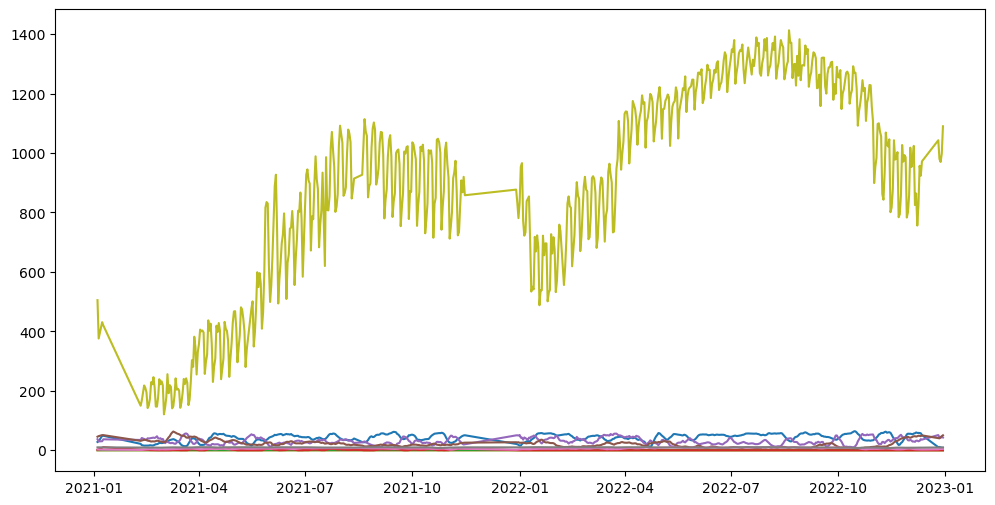

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

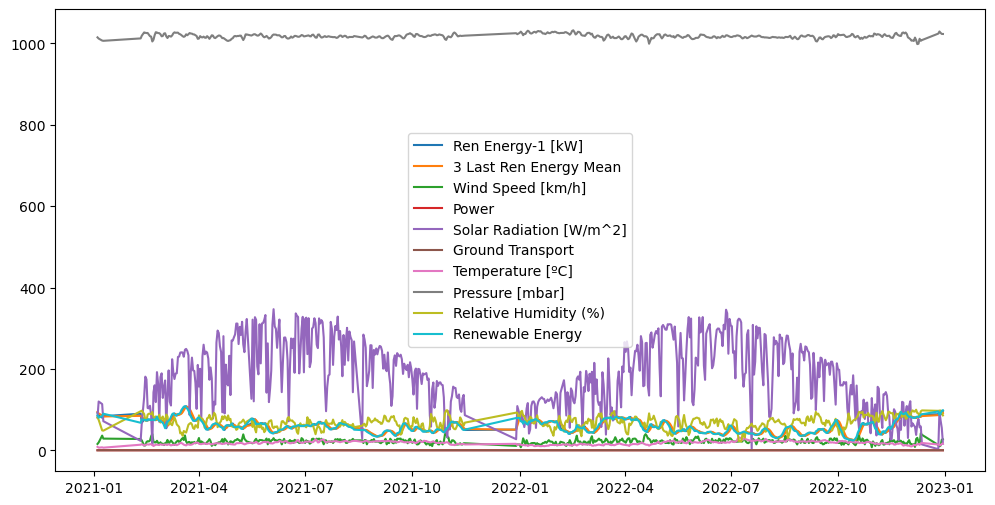

<Figure size 1700x600 with 0 Axes>

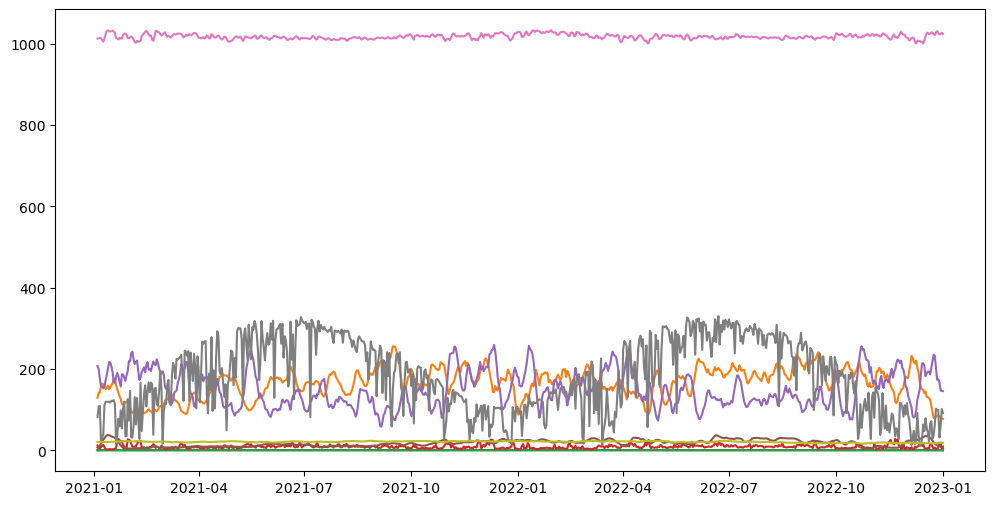

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

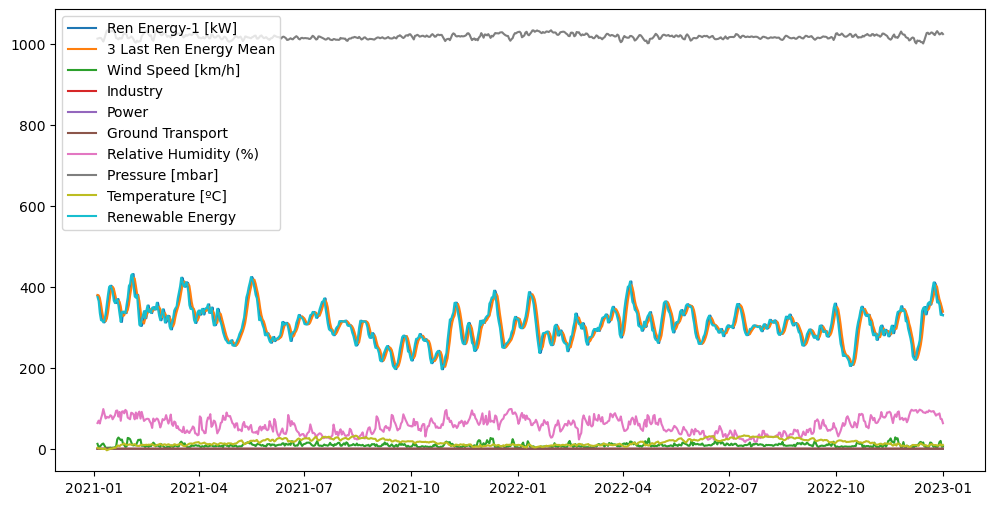

<Figure size 1700x600 with 0 Axes>

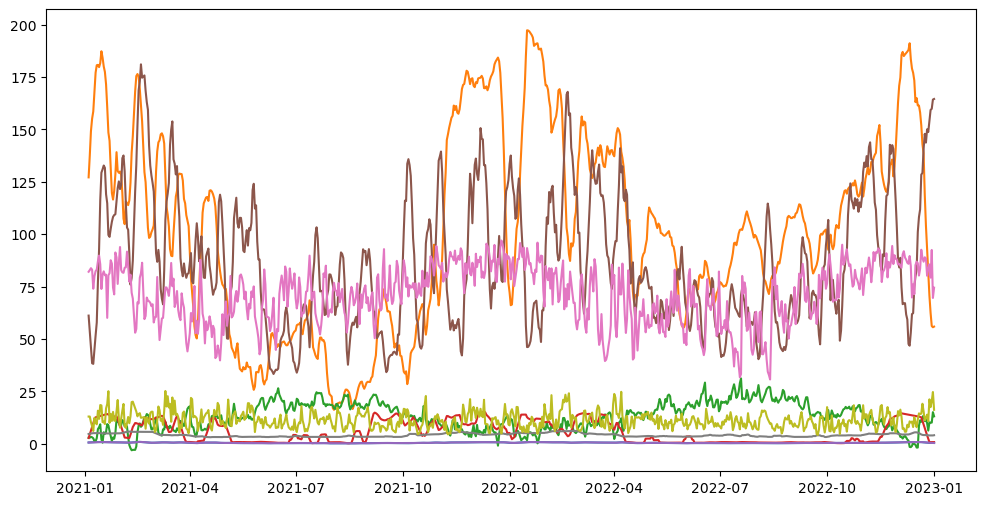

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

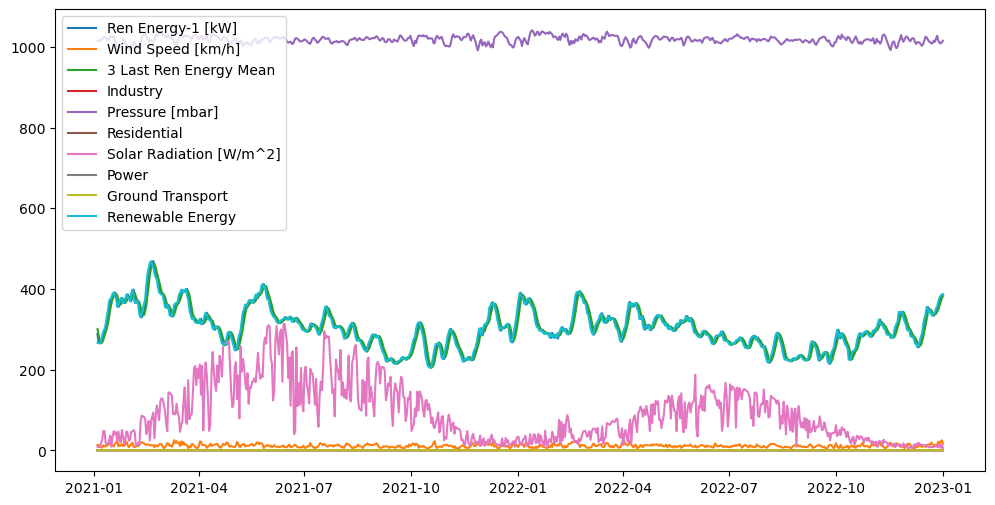

<Figure size 1700x600 with 0 Axes>

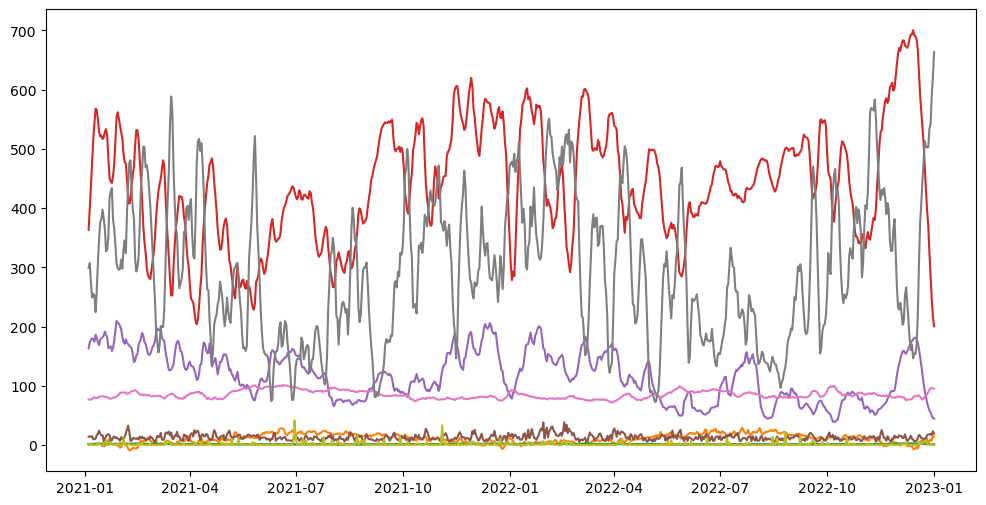

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

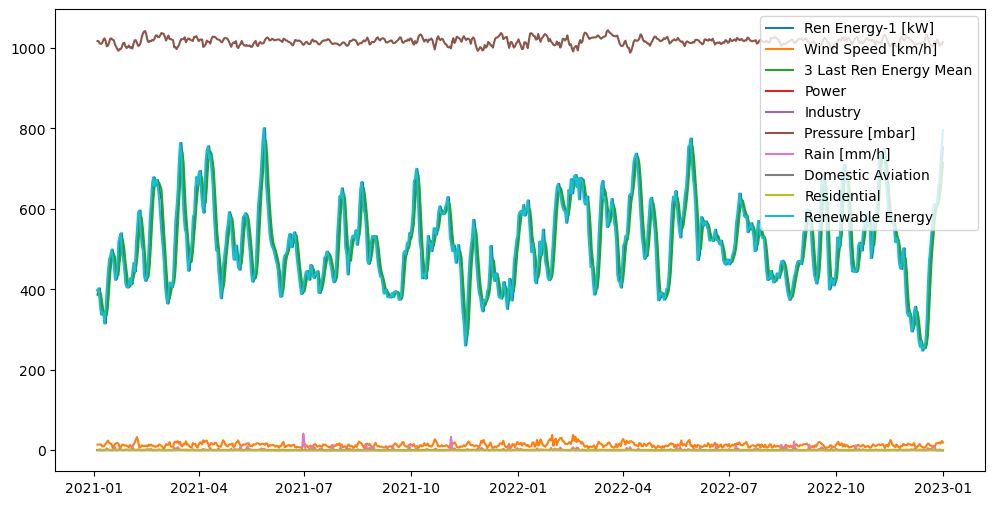

<Figure size 1700x600 with 0 Axes>

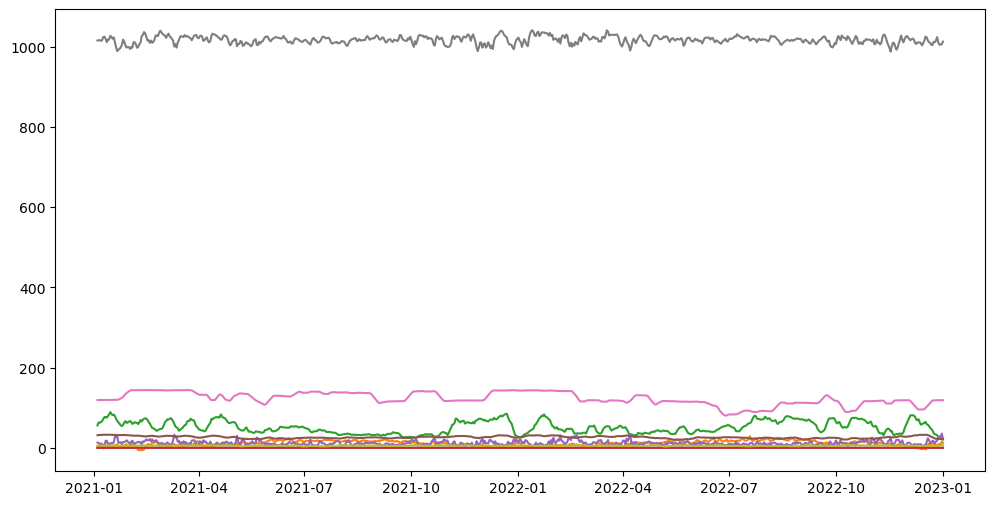

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

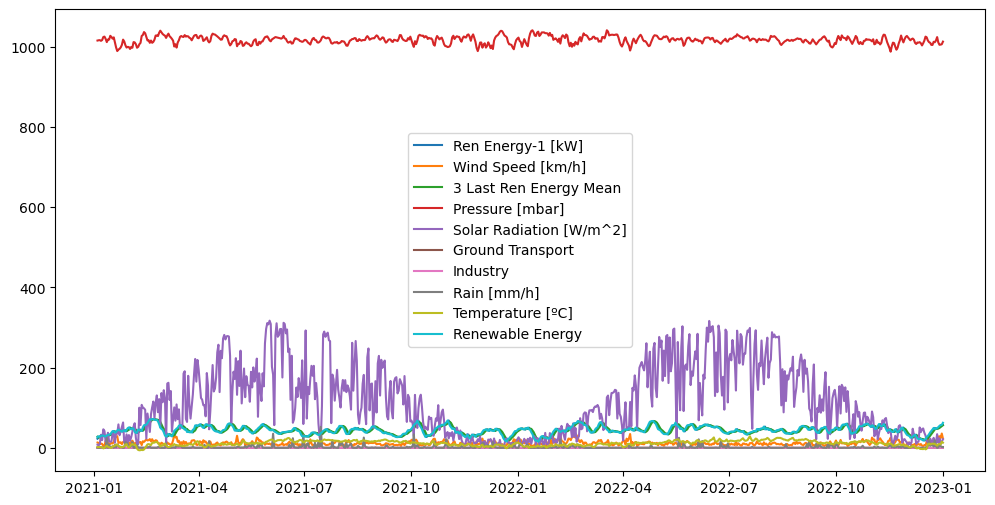

<Figure size 1700x600 with 0 Axes>

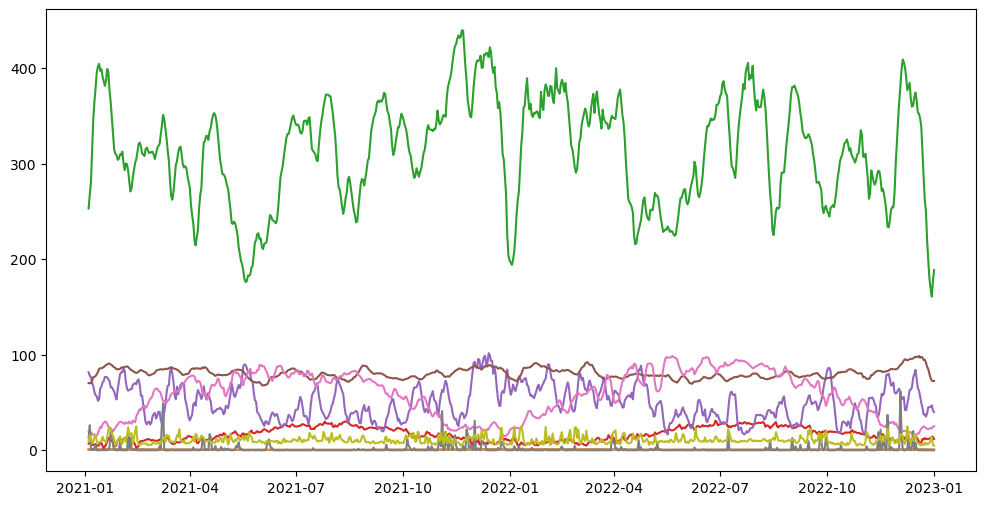

<Figure size 1200x600 with 0 Axes>

<Figure size 1700x600 with 0 Axes>

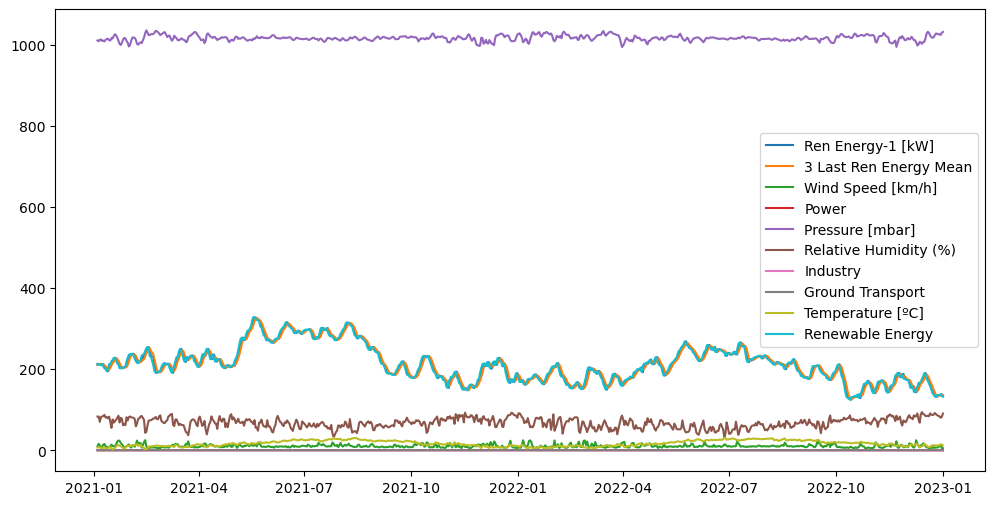

In [14]:
for country in countries:
     
    #só estou a meter como outputs o CO2 emission e o Renewable energy (isoladamente) e aqui a criar a média dos ultimos 3 valores e o valor anterior
    
    globals()[f"{country.replace(' ', '_')}"]['CO2 Emission-1 [kW]']=globals()[f"{country.replace(' ', '_')}"]['Total CO2 [Tonne]'].shift(1) # Previous hour consumption
    globals()[f"{country.replace(' ', '_')}"]["3 Last CO2 Mean"] = globals()[f"{country.replace(' ', '_')}"]['Total CO2 [Tonne]'].rolling(window=4).apply(lambda x: x[-4:-1].mean(), raw=True) #mean of the last three consumption values for each index
    globals()[f"{country.replace(' ', '_')}"]['Ren Energy-1 [kW]']=globals()[f"{country.replace(' ', '_')}"]['Total Renewable [GWh]'].shift(1) # Previous hour consumption
    globals()[f"{country.replace(' ', '_')}"]["3 Last Ren Energy Mean"] = globals()[f"{country.replace(' ', '_')}"]['Total Renewable [GWh]'].rolling(window=4).apply(lambda x: x[-4:-1].mean(), raw=True) #mean of the last three consumption values for each index
    
    globals()[f"{country.replace(' ', '_')}"]=globals()[f"{country.replace(' ', '_')}"].dropna() 
    
    # Fica aqui uma lista só para ser mais fácil identificar o indice de cada variável
    
    """
    0 : country', 
    1 :'Power', 
    2: 'Ground Transport', 
    3:'International Aviation',
    4:   'Residential', 
    5:   'Industry', 
    6:   'Domestic Aviation', 
    7:   'Total CO2 [Tonne]',
    8:   'Temperature [ºC]', 
    9:   'Relative Humidity (%)', 
    10:   'Rain [mm/h]',
    11:   'Wind Speed [km/h]', 
    12:   'Pressure [mbar]', 
    13:   'Solar Radiation [W/m^2]',
    14:   'Other sources', 
    15:   'Gas', 
    16:   'Oil', 
    17:   'Coal', 
    18:   'Wind', 
    19:   'Nuclear', 
    20:   'Solar',
    21:   'Hydroelectricity', 
    22:   'Total Renewable [GWh]',
    23:   'Total Non-Renewable [GWh]', 
    24:   'Total Electricity [GWh]', 
    25:   'Flights',
    26:   'CO2 Emission-1 [kW]', 
    27:   '3 Last CO2 Mean', 
    28:   'Ren Energy-1 [kW]',
    29   '3 Last Ren Energy Mean'],
    
    """
    
    ############################# Para o CO2 emissions ##################################################################################################
    
    Z= globals()[f"{country.replace(' ', '_')}"].values
    Y_co=Z[:,7]
    
    print(globals()[f"{country.replace(' ', '_')}"].columns)
    
    X_co=Z[:,[8,9,10,11,12,13,14,15,16,17,18,19,20,21,25,26,27]] 
    features=SelectKBest(k=2,score_func=mutual_info_regression)
    fit=features.fit(X_co,Y_co) #calculates the scores using the score_function f_regression of the features
    features_results=fit.transform(X_co)
    plt.figure(figsize=(17,6))
    
    features = globals()[f"{country.replace(' ', '_')}"].columns.tolist()[8:22] + globals()[f"{country.replace(' ', '_')}"].columns.tolist()[25:28]
    
    plt.bar(features, fit.scores_, color="red")
    plt.xlabel("k")
    plt.ylabel("Fit Score")
    plt.title(f'{country}')
    plt.xticks(rotation=90) 
    plt.subplots_adjust(bottom=0.27)
    plt.savefig(f"features_tests/fitscore_CO2_{country}.png") 
    plt.clf()
    
    high_feat_temp=dict(zip(features, fit.scores_))
    high_feat_temp = dict(sorted(high_feat_temp.items(), key=lambda item: item[1], reverse=True))
    
    kbest_points = {feature: (len(high_feat_temp) - i) for i, (feature, _) in enumerate(high_feat_temp.items())}
    
    print(f"Highest features scores for CO2 as Output with kBest for {country}:\n")
    for i, (column, score) in enumerate(high_feat_temp.items()):
        if i < 9:
            print(f"{column}: {score}")
        else:
            break
    print("\n")
    
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor() 
    model.fit(X_co, Y_co)
    high_feat_temp=dict(zip(features, model.feature_importances_))
    high_feat_temp = dict(sorted(high_feat_temp.items(), key=lambda item: item[1], reverse=True))
    
    rf_points = {feature: (len(high_feat_temp) - i) for i, (feature, _) in enumerate(high_feat_temp.items())}
    plt.figure(figsize=(12,6))
    print("Highest features importances for CO2 as Output with RandomForestRegressor:\n")
    for i, (column, score) in enumerate(high_feat_temp.items()):
        if i < 9:
            print(f"{column}: {score}")
            plt.plot(globals()[f"{country.replace(' ', '_')}"][column], label=f"{column}")
        else:
            break
    print("\n")
    

    # Combine points from both methods
    total_points = {}
    
    for feature in high_feat_temp.keys():
        total_points[feature] = rf_points.get(feature, 0) + kbest_points.get(feature, 0)

    # Sort features based on total points
    sorted_features = sorted(total_points.items(), key=lambda x: x[1], reverse=True)

    # Select the top features
    high_feat_temp_co[f"high_feat_temp_{country}"] = sorted_features[:9]
    
    
    print("Best features for CO2 emission after both tests:")
    print(high_feat_temp_co[f"high_feat_temp_{country}"])
    
    plt.figure(figsize=(12,6))
    
    for (column,value) in high_feat_temp_co[f"high_feat_temp_{country}"]:
        plt.plot(globals()[f"{country.replace(' ', '_')}"][column], label=f"{column}")
    plt.plot(globals()[f"{country.replace(' ', '_')}"]["Total CO2 [Tonne]"], label=f"Total CO^2 Emission")
    
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Variables")
    plt.title(f'{country}')
    plt.subplots_adjust(bottom=0.27)
    plt.savefig(f"features_tests/best_feat_{country}.png") 
    plt.clf()
    
    
    ############################################ Para a Ren Energy ##################################################################################
    Y_en=Z[:,22]
    
    X_en=Z[:,[1,2,3,4,5,6,8,9,10,11,12,13,25,28,29]] 
    features=SelectKBest(k=2,score_func=mutual_info_regression)
    fit=features.fit(X_en,Y_en) #calculates the scores using the score_function f_regression of the features
    features_results=fit.transform(X_en)
    plt.figure(figsize=(17,6))
    
    features = globals()[f"{country.replace(' ', '_')}"].columns.tolist()[1:7] + globals()[f"{country.replace(' ', '_')}"].columns.tolist()[8:14] + [globals()[f"{country.replace(' ', '_')}"].columns.tolist()[25]] + globals()[f"{country.replace(' ', '_')}"].columns.tolist()[28:]
    
    plt.bar(features, fit.scores_, color="lime")
    plt.xlabel("k")
    plt.ylabel("Fit Score")
    plt.title(f'{country}')
    plt.xticks(rotation=90) 
    plt.subplots_adjust(bottom=0.27)
    plt.savefig(f"features_tests/fitscore_Renewable_{country}.png") 
    plt.clf()
    
    high_feat_temp=dict(zip(features, fit.scores_))
    
    high_feat_temp = dict(sorted(high_feat_temp.items(), key=lambda item: item[1], reverse=True))
    kbest_points = {feature: (len(high_feat_temp) - i) for i, (feature, _) in enumerate(high_feat_temp.items())}
    
    print(f"Highest features scores for Renewable Energy as Output with kBest for {country}:\n")
    for i, (column, score) in enumerate(high_feat_temp.items()):
        if i < 9:
            print(f"{column}: {score}")
        else:
            break
    print("\n")
    
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor() 
    model.fit(X_en, Y_en)
    high_feat_temp=dict(zip(features, model.feature_importances_))
    high_feat_temp = dict(sorted(high_feat_temp.items(), key=lambda item: item[1], reverse=True))
    
    rf_points = {feature: (len(high_feat_temp) - i) for i, (feature, _) in enumerate(high_feat_temp.items())}
    plt.figure(figsize=(12,6))
    print("Highest features importances for Renewable energy as Output with RandomForestRegressor:\n")
    for i, (column, score) in enumerate(high_feat_temp.items()):
        if i < 9:
            print(f"{column}: {score}")
            plt.plot(globals()[f"{country.replace(' ', '_')}"][column], label=f"{column}")
        else:
            break
    print("\n")
    
    plt.plot(globals()[f"{country.replace(' ', '_')}"]["Total Renewable [GWh]"], label=f"Renewable Energy")
    plt.legend()

    # Combine points from both methods
    total_points = {}
    
    for feature in high_feat_temp.keys():
        total_points[feature] =  kbest_points.get(feature, 0) + rf_points.get(feature, 0) 

    # Sort features based on total points
    sorted_features = sorted(total_points.items(), key=lambda x: x[1], reverse=True)

    # Select the top features
    high_feat_temp_en[f"high_feat_temp_{country}"] = sorted_features[:9]
    
    print("Best features for Renewable Energy after both tests:")
    print(high_feat_temp_en[f"high_feat_temp_{country}"])

################################################ Random Forest Model ##########################################################################

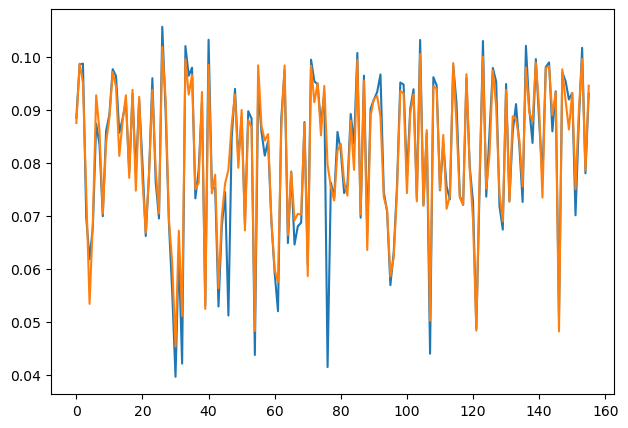

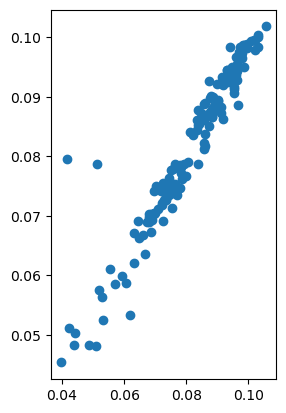

Portugal
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-06              11.0                   92.5        0.000   
2023-01-07              14.7                   95.7        0.400   
2023-01-08              16.2                   94.7       12.600   
2023-01-09              15.5                   92.7        4.007   
2023-01-10              14.4                   95.8        0.000   
...                      ...                    ...          ...   
2023-12-15              11.1                   74.6        0.000   
2023-12-16              11.1                   77.2        0.000   
2023-12-17               9.6                   84.2        0.000   
2023-12-18               8.4                   87.4        0.000   
2023-12-19               8.2                   86.0        0.017   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                   

<Figure size 640x480 with 0 Axes>

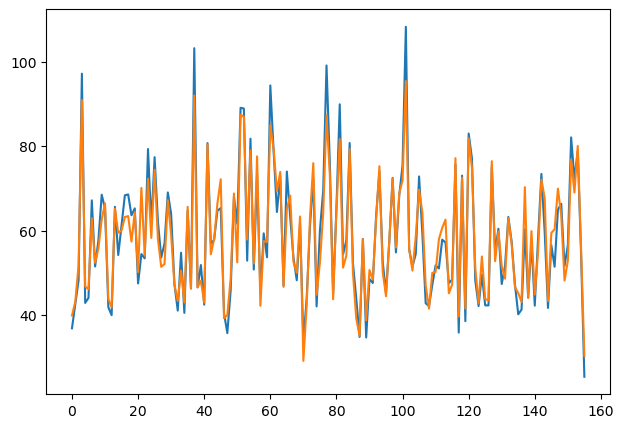

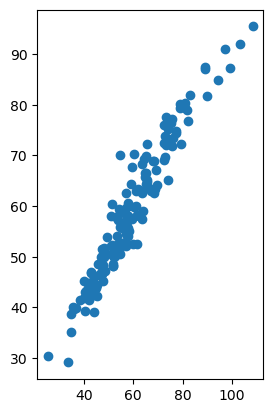

Portugal
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-06              11.0                   92.5        0.000   
2023-01-07              14.7                   95.7        0.400   
2023-01-08              16.2                   94.7       12.600   
2023-01-09              15.5                   92.7        4.007   
2023-01-10              14.4                   95.8        0.000   
...                      ...                    ...          ...   
2023-12-15              11.1                   74.6        0.000   
2023-12-16              11.1                   77.2        0.000   
2023-12-17               9.6                   84.2        0.000   
2023-12-18               8.4                   87.4        0.000   
2023-12-19               8.2                   86.0        0.017   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                   

<Figure size 640x480 with 0 Axes>

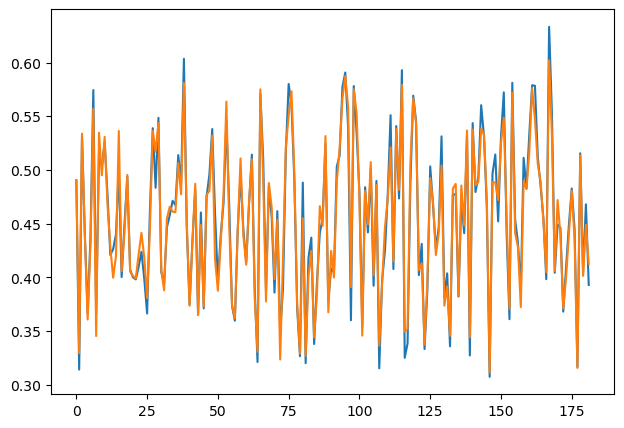

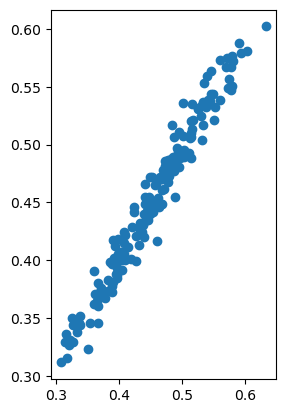

Spain
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01               9.5                   63.3        0.204   
2023-01-02              10.1                   82.1        0.237   
2023-01-03               7.8                   80.4        0.000   
2023-01-04               6.2                   77.3        0.000   
2023-01-05               6.1                   73.7        0.000   
...                      ...                    ...          ...   
2023-12-27               3.2                   83.5        0.000   
2023-12-28               2.9                   83.8        0.000   
2023-12-29               4.7                   83.0        0.000   
2023-12-30               5.3                   82.1        0.000   
2023-12-31               6.7                   90.2        0.032   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                      

<Figure size 640x480 with 0 Axes>

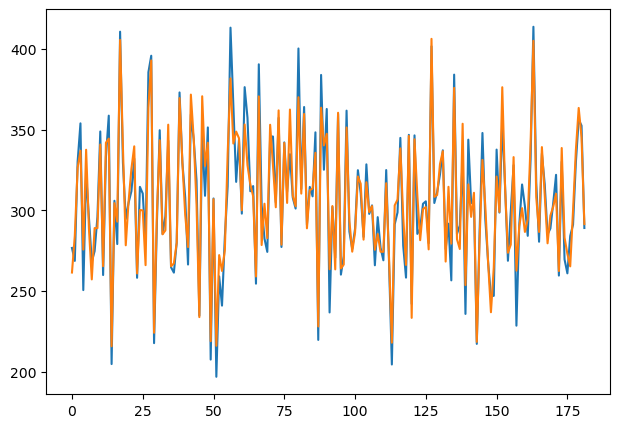

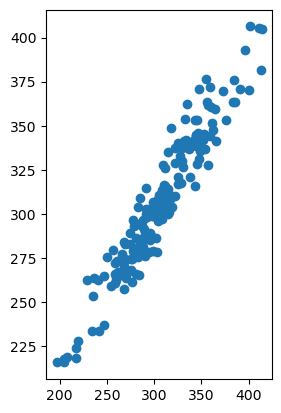

Spain
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01               9.5                   63.3        0.204   
2023-01-02              10.1                   82.1        0.237   
2023-01-03               7.8                   80.4        0.000   
2023-01-04               6.2                   77.3        0.000   
2023-01-05               6.1                   73.7        0.000   
...                      ...                    ...          ...   
2023-12-27               3.2                   83.5        0.000   
2023-12-28               2.9                   83.8        0.000   
2023-12-29               4.7                   83.0        0.000   
2023-12-30               5.3                   82.1        0.000   
2023-12-31               6.7                   90.2        0.032   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                      

<Figure size 640x480 with 0 Axes>

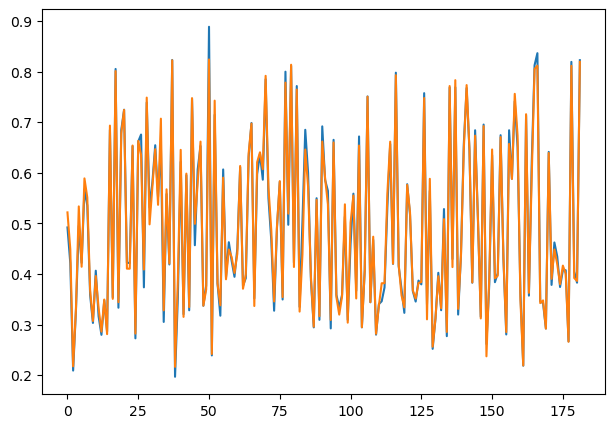

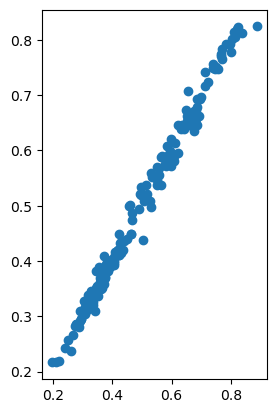

France
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              13.1                   74.5        1.030   
2023-01-02              10.7                   84.7        3.365   
2023-01-03               7.6                   92.4        0.575   
2023-01-04              11.7                   90.4        0.976   
2023-01-05              12.5                   84.9        0.395   
...                      ...                    ...          ...   
2023-12-27               9.5                   74.7        0.007   
2023-12-28              10.3                   84.3        0.000   
2023-12-29              10.4                   84.9        1.231   
2023-12-30               9.2                   89.5        0.034   
2023-12-31               9.3                   74.8        1.059   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                     

<Figure size 640x480 with 0 Axes>

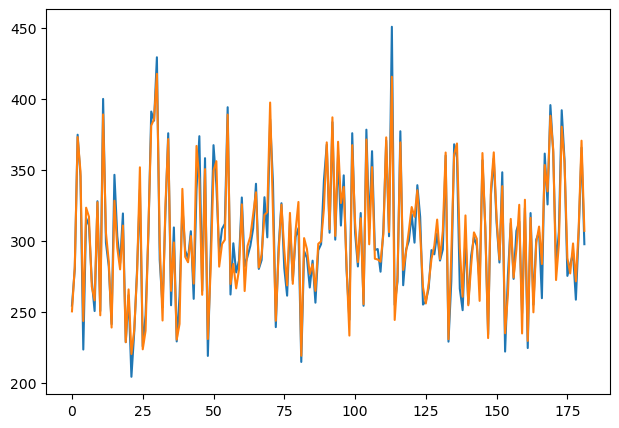

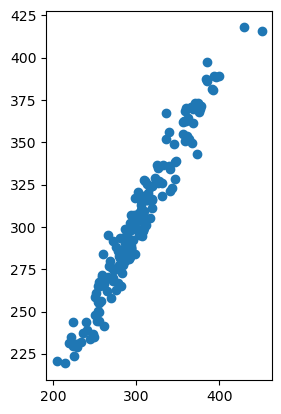

France
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              13.1                   74.5        1.030   
2023-01-02              10.7                   84.7        3.365   
2023-01-03               7.6                   92.4        0.575   
2023-01-04              11.7                   90.4        0.976   
2023-01-05              12.5                   84.9        0.395   
...                      ...                    ...          ...   
2023-12-27               9.5                   74.7        0.007   
2023-12-28              10.3                   84.3        0.000   
2023-12-29              10.4                   84.9        1.231   
2023-12-30               9.2                   89.5        0.034   
2023-12-31               9.3                   74.8        1.059   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                     

<Figure size 640x480 with 0 Axes>

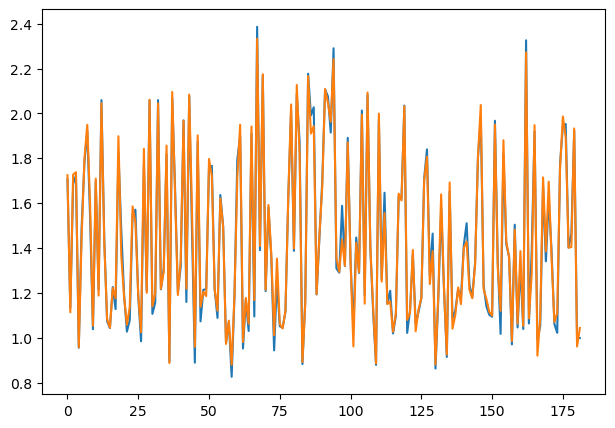

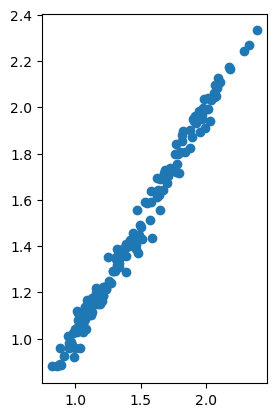

Germany
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              14.5                   61.3        0.000   
2023-01-02              13.1                   66.8        0.117   
2023-01-03               5.6                   81.7        0.005   
2023-01-04               6.7                   88.9       11.803   
2023-01-05               8.4                   78.3        7.030   
...                      ...                    ...          ...   
2023-12-27               4.2                   82.5        0.000   
2023-12-28               8.3                   72.0        0.105   
2023-12-29               9.6                   73.0        0.953   
2023-12-30               6.6                   81.0        3.040   
2023-12-31               5.3                   86.6        0.000   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                    

<Figure size 640x480 with 0 Axes>

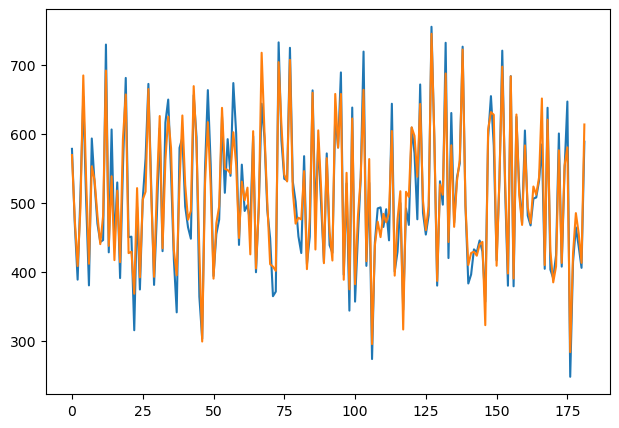

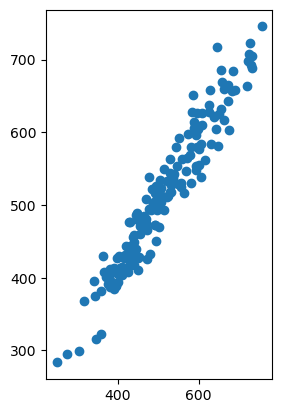

Germany
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              14.5                   61.3        0.000   
2023-01-02              13.1                   66.8        0.117   
2023-01-03               5.6                   81.7        0.005   
2023-01-04               6.7                   88.9       11.803   
2023-01-05               8.4                   78.3        7.030   
...                      ...                    ...          ...   
2023-12-27               4.2                   82.5        0.000   
2023-12-28               8.3                   72.0        0.105   
2023-12-29               9.6                   73.0        0.953   
2023-12-30               6.6                   81.0        3.040   
2023-12-31               5.3                   86.6        0.000   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                    

<Figure size 640x480 with 0 Axes>

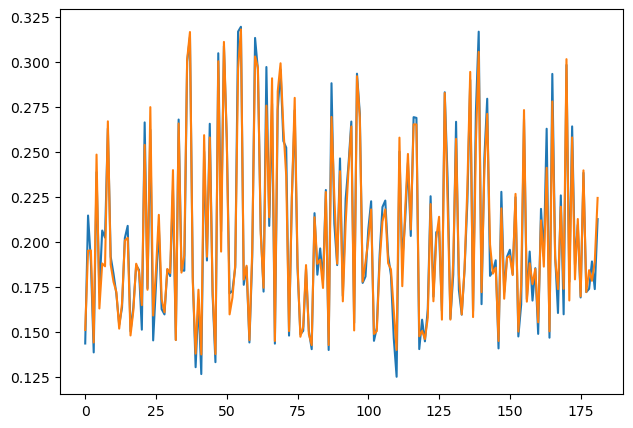

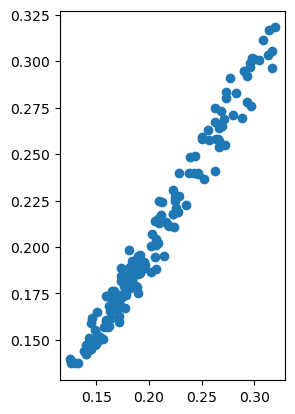

Belgium
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              13.0                   74.0        2.142   
2023-01-02               9.9                   91.9        7.262   
2023-01-03               6.8                   91.2        0.561   
2023-01-04              11.2                   90.2        3.316   
2023-01-05              10.7                   89.8        1.269   
...                      ...                    ...          ...   
2023-12-27               8.5                   83.1        0.136   
2023-12-28              10.5                   77.4        0.040   
2023-12-29               9.8                   86.8        5.878   
2023-12-30               8.7                   87.6        1.849   
2023-12-31               9.1                   76.4        0.468   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                    

<Figure size 640x480 with 0 Axes>

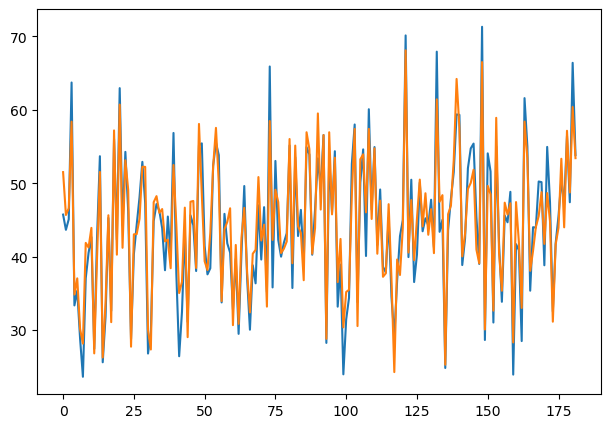

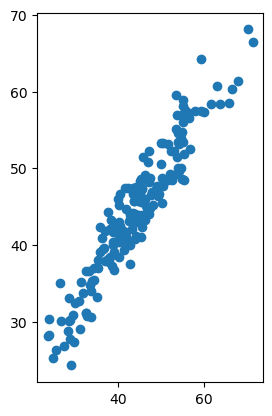

Belgium
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              13.0                   74.0        2.142   
2023-01-02               9.9                   91.9        7.262   
2023-01-03               6.8                   91.2        0.561   
2023-01-04              11.2                   90.2        3.316   
2023-01-05              10.7                   89.8        1.269   
...                      ...                    ...          ...   
2023-12-27               8.5                   83.1        0.136   
2023-12-28              10.5                   77.4        0.040   
2023-12-29               9.8                   86.8        5.878   
2023-12-30               8.7                   87.6        1.849   
2023-12-31               9.1                   76.4        0.468   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                    

<Figure size 640x480 with 0 Axes>

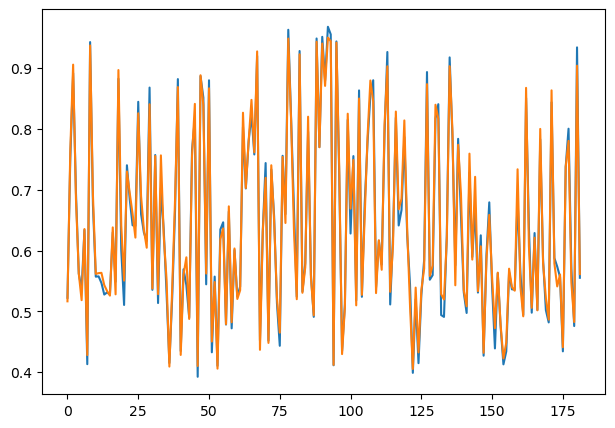

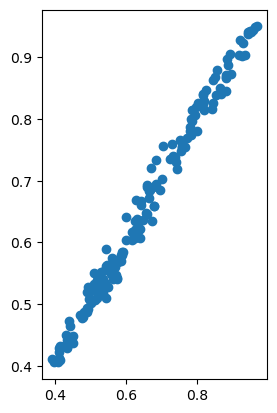

Italy
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              11.8                   90.4        0.000   
2023-01-02              11.6                   87.9        0.043   
2023-01-03              11.8                   88.2        0.000   
2023-01-04              10.6                   88.3        0.000   
2023-01-05               8.9                   92.3        0.043   
...                      ...                    ...          ...   
2023-12-27              11.4                   72.6        0.000   
2023-12-28               9.1                   81.3        0.000   
2023-12-29              12.3                   75.2        0.000   
2023-12-30              12.7                   77.5        0.000   
2023-12-31              11.8                   85.9        0.641   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                      

<Figure size 640x480 with 0 Axes>

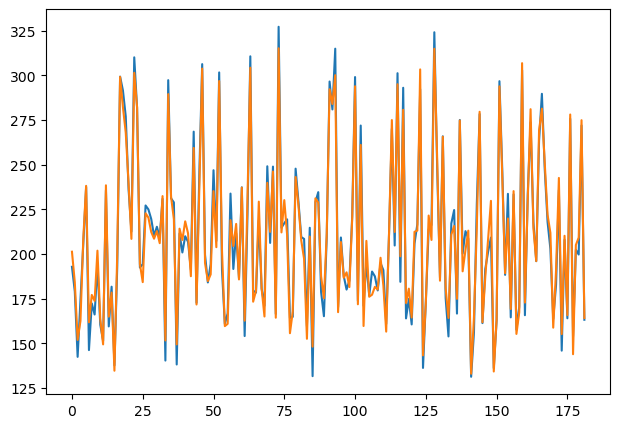

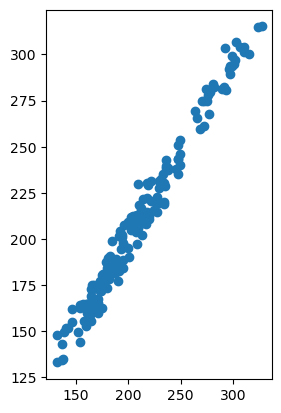

Italy
365
365
            Temperature [ºC]  Relative Humidity (%)  Rain [mm/h]  \
Date                                                               
2023-01-01              11.8                   90.4        0.000   
2023-01-02              11.6                   87.9        0.043   
2023-01-03              11.8                   88.2        0.000   
2023-01-04              10.6                   88.3        0.000   
2023-01-05               8.9                   92.3        0.043   
...                      ...                    ...          ...   
2023-12-27              11.4                   72.6        0.000   
2023-12-28               9.1                   81.3        0.000   
2023-12-29              12.3                   75.2        0.000   
2023-12-30              12.7                   77.5        0.000   
2023-12-31              11.8                   85.9        0.641   

            Wind Speed [km/h]  Pressure [mbar]  Solar Radiation [W/m^2]  \
Date                      

<Figure size 640x480 with 0 Axes>

In [15]:
for country in countries:
    options=[high_feat_temp_co[f"high_feat_temp_{country}"],high_feat_temp_en[f"high_feat_temp_{country}"] ]
    
    for option in options:
        
        df_forecast=pd.DataFrame()
        if option==high_feat_temp_co[f"high_feat_temp_{country}"]:   
            df_forecast["Total CO2 [Tonne]"]=globals()[f"{country.replace(' ', '_')}"]["Total CO2 [Tonne]"]
        elif option==high_feat_temp_en[f"high_feat_temp_{country}"]:
            df_forecast["Total Renewable [GWh]"]=globals()[f"{country.replace(' ', '_')}"]["Total Renewable [GWh]"]
        
        for feat in option:
            df_forecast[feat[0]]=(globals()[f"{country.replace(' ', '_')}"][f"{feat[0]}"])
            
        Z=df_forecast.values
        
        Y=Z[:, 0]
        #Identify input Y
        X=Z[:,[1,2,3,4,5,6]]  # Temperature,Solar Radiation, Power-1, average value of last three data values
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.preprocessing import StandardScaler
        parameters = {'bootstrap': True,
                    'min_samples_leaf': 4,
                    'n_estimators': 1030, 
                    'min_samples_split': 2,
                    'max_features': "sqrt",
                    'max_depth': 70,
                    'max_leaf_nodes': None}
        RF_model = RandomForestRegressor(**parameters)
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
        RF_model.fit(X_train, Y_train)
        y_pred_RF = RF_model.predict(X_test)
        fig = plt.figure(figsize=(16,5))
        plt.subplot(1, 2, 1)
        plt.plot(Y_test)
        plt.plot(y_pred_RF)
        plt.show()
        plt.subplot(1, 2, 2)
        plt.scatter(Y_test,y_pred_RF)
        plt.show()
        MAE_RF, MBE_RF,MSE_RF, RMSE_RF,cvRMSE_RF,NMBE_RF= evaluating_models(Y_test,y_pred_RF)
        fig.text(0.5, 0.02, f'Mean Absolute Error: {round(MAE_RF,4)}   Mean Bias Error: {round(MBE_RF,4)}   Mean Squared Error: {round(MSE_RF,4)}    Root Mean Squared Error: {round(RMSE_RF,4)}   cvRMSE: {round(cvRMSE_RF,4)}  Normalized Mean Bias Error: {round(NMBE_RF,4)}', ha='center', va='center', fontsize=12, color='black')
        plt.show()
        if option==high_feat_temp_co[f"high_feat_temp_{country}"]: 
            plt.title(f'CO2 emission training for {country} with RF')
            plt.savefig(f"regressions/co2/rf_co2_{country}.png")   
            
        elif option==high_feat_temp_en[f"high_feat_temp_{country}"]:
            plt.title(f'Renewable energy training for {country} with RF')
            plt.savefig(f"regressions/energy/rf_en_{country}.png") 
        plt.clf()

        ######################################################## RF With Uniformized data ##################################################################################################################
        
        scaler = StandardScaler()
        # Fit only to the training data
        scaler.fit(X_train)

        # Now apply the transformations to the data:
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        parameters = {'bootstrap': True,
                    'min_samples_leaf': 4,
                    'n_estimators': 1030, 
                    'min_samples_split': 2,
                    'max_features': "sqrt",
                    'max_depth': 70,
                    'max_leaf_nodes': None}
        RF_model_uni= RandomForestRegressor(**parameters)
        
################################################### DATA TESTE ####################################################################################################
        
        print(country)
        df_test= pd.read_csv(f'test_data/{country}_Test.csv', index_col = False)

        date_range= pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
        
        print(len(date_range))  # Check the length of date_range
        print(len(df_test)) 
        
        df_test.index = date_range

        df_test.index.name="Date"
        
        df_test.rename(columns={'temp': 'Temperature [ºC]', 'windspeed': 'Wind Speed [km/h]',"humidity": 'Relative Humidity (%)',
                                    'sealevelpressure': 'Pressure [mbar]','solarradiation': 'Solar Radiation [W/m^2]', 'precip': 'Rain [mm/h]'}, inplace=True)

        
        df_carbon = carbon_eu[(carbon_eu['country'] == country)] 
        
        for sector in sectors_co2:
            sector_list = df_carbon[(df_carbon['sector'] == sector)]
            sector_list = sector_list.drop(columns=['timestamp','sector'])
            sector_list.rename(columns={'value': f'{sector}', 'date': 'Date'}, inplace=True)
            globals()[f"{sector.replace(' ', '_')}"]= sector_list 

        df_carbon = pd.merge(Power, Ground_Transport, on=["Date","country"], how='inner')

        # Merge all types of energy 

        df_carbon  = pd.merge(df_carbon , International_Aviation, on=["Date","country"], how='inner')

        df_carbon  = pd.merge(df_carbon , Residential, on=["Date","country"], how='inner')

        df_carbon = pd.merge(df_carbon , Industry, on=["Date","country"], how='inner')

        df_carbon  = pd.merge(df_carbon , Domestic_Aviation, on=["Date","country"], how='inner')

        
        df_carbon["Total CO2 [Tonne]"]= df_carbon["Power"]+df_carbon["International Aviation"]+df_carbon["Residential"]+df_carbon["Industry"]+df_carbon["Domestic Aviation"]

        df_carbon[['Day','Month','Year']] = df_carbon.Date.str.split("/",expand=True) 

        df_carbon = df_carbon.drop(columns=['Date'])

        df_carbon['Date'] = pd.to_datetime(df_carbon[['Day', 'Month', 'Year']])

        df_carbon = df_carbon.drop(columns=['Year', 'Month', 'Day'])

        df_carbon.set_index('Date', inplace=True)
        
        df_en = energy_prod[(energy_prod['country'] == country)] 
        
        for sector in sectors_en:
            sector_list = df_en[(df_en['sector'] == sector)]
            sector_list = sector_list.drop(columns=['timestamp','sector'])
            sector_list.rename(columns={'value': f'{sector}', 'date': 'Date'}, inplace=True)
            globals()[f"{sector.replace(' ', '_')}"]= sector_list 

        df_en = pd.merge(Other_sources, Gas, on=["Date","country"], how='inner')

        # Merge all types of energy 

        df_en  = pd.merge(df_en , Oil, on=["Date","country"], how='inner')

        df_en  = pd.merge(df_en , Coal, on=["Date","country"], how='inner')

        df_en  = pd.merge(df_en ,  Wind, on=["Date","country"], how='inner')

        df_en  = pd.merge(df_en ,Nuclear, on=["Date","country"], how='inner')
        
        df_en  = pd.merge(df_en ,Solar, on=["Date","country"], how='inner')
        
        df_en  = pd.merge(df_en ,Hydroelectricity, on=["Date","country"], how='inner')
        
        df_en["Total Renewable [GWh]"]= df_en["Wind"]+ df_en["Solar"] + df_en["Hydroelectricity"]

        df_en["Total Non-Renewable [GWh]"]= df_en["Other sources"]+df_en["Gas"]+df_en["Oil"]+df_en["Coal"]+ df_en["Nuclear"]
        
        df_en["Total Electricity [GWh]"]= df_en["Other sources"]+df_en["Gas"]+df_en["Oil"]+df_en["Coal"]+df_en["Wind"]+ df_en["Nuclear"] + df_en["Solar"] + df_en["Hydroelectricity"]
        
        df_en[['Day','Month','Year']] = df_en.Date.str.split("/",expand=True) 

        df_en = df_en.drop(columns=['Date'])

        df_en['Date'] = pd.to_datetime(df_en[['Day', 'Month', 'Year']])

        df_en = df_en.drop(columns=['Year', 'Month', 'Day'])

        df_en.set_index('Date', inplace=True)
        
        df_test  = pd.merge(df_test , df_carbon, on=["Date"], how='inner')
        
        df_test  = pd.merge(df_test, df_en, on=["Date","country"], how='inner')
        
        df_test=df_test.dropna() 
        
        df_list=[]
        
        flights = pd.read_excel(f"flights_data/2023flight.xlsx", sheet_name="Data")
        
        flights['Year'] = flights['Day'].dt.year
        flights['Month'] = flights['Day'].dt.month
        flights['Day'] = flights['Day'].dt.day

        flights['Date'] = pd.to_datetime(flights[['Year', 'Month', 'Day']])

        flights = flights.drop(columns=['Year','Week', 'Month', 'Day','Flights (7-day moving average)','Day 2019', 'Flights 2019 (Reference)',	'% vs 2019 (Daily)','% vs 2019 (7-day Moving Average)',	'Day Previous Year',	'Flights Previous Year'])

        flights.set_index('Date', inplace=True)
        
        flights.rename(columns={'Entity':'country'}, inplace=True)

        
        df_test  = pd.merge(df_test , flights, on=["Date","country"], how='inner')
        
        if "datetime" in df_test:
            df_test = df_test.drop(columns=['datetime'])
            
        print(df_test)
        
        df_test['CO2 Emission-1 [kW]']=df_test['Total CO2 [Tonne]'].shift(1) # Previous hour consumption

        df_test["3 Last CO2 Mean"] = df_test['Total CO2 [Tonne]'].rolling(window=4).apply(lambda x: x[-4:-1].mean(), raw=True) #mean of the last three consumption values for each index

        df_test['Ren Energy-1 [kW]']=df_test['Total Renewable [GWh]'].shift(1) # Previous hour consumption

        df_test["3 Last Ren Energy Mean"] = df_test['Total Renewable [GWh]'].rolling(window=4).apply(lambda x: x[-4:-1].mean(), raw=True) #mean of the last three consumption values for each index
        
        df_test=df_test.dropna() 
        
        ########################################################### FORECASTING PARA 2023 #######################################################################################################################
        
        forecast_test=pd.DataFrame()

        if option==high_feat_temp_co[f"high_feat_temp_{country}"]:   
            forecast_test["Total CO2 [Tonne]"]=df_test["Total CO2 [Tonne]"]
        elif option==high_feat_temp_en[f"high_feat_temp_{country}"]:
            forecast_test["Total Renewable [GWh]"]=df_test["Total Renewable [GWh]"]
        
        for feat in option:
            forecast_test[feat[0]]=df_test[f"{feat[0]}"]
            
        Z_test=forecast_test.values
        
        Y_test=Z

